# Problem conversion

Moving from raw problem instance data to MCAPRTIF via pytables.

In [1]:
%load_ext autoreload
%autoreload 2

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import logging
logging.basicConfig(level=logging.INFO)

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

import os
import sys
sys.path.insert(0, os.path.abspath('../../'))

In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np

In [6]:
from osmnx_network_extract.extract_mcarptif import NetworkExtract
from visualise.route_tables import RouteSummary
from solver import solve_store_instance
from osmnx_network_extract.network_code import create_gdf
from osmnx_network_extract.network_code import required_arc_plot

In [8]:
network_file = '../../../hobbes_projects/wasted_large_instances/outputs/city_punggol_full_internal_50m_buffer.h5'
test_network = pd.read_csv('../../../hobbes_projects/wasted_large_instances/outputs/city_punggol_full_internal_50m_buffer_original_dataframe.csv')
test_network = test_network.drop(columns=['Unnamed: 0'])
test_network_plot = create_gdf(test_network, dropna_geom=True)

## Large instance calculation test

In [118]:
test_size = 1500

sample = np.random.randint(0, test_network.shape[0], size=test_size)
sample = np.unique(sample)
req_arcs = test_network.iloc[sample, :].copy()
req_arcs = req_arcs.sort_values(['arc_index'])
req_arcs = req_arcs.drop_duplicates(['arc_id_ordered'])
req_arcs = req_arcs.dropna(subset=['geometry'])
req_arcs = create_gdf(req_arcs, crs='')

In [119]:
%%time
network_info = NetworkExtract(test_network, network_file, round_cost=True)

depot = req_arcs['arc_index'].iloc[0]
ifs = req_arcs['arc_index'].iloc[-4:]

network_info.load_required_arcs(req_arcs)
network_info.set_depot_arc(depot)
network_info.set_if_arcs(ifs)
network_info.loc_in_required_arcs()
network_info.extend_required_inverse_arcs()
network_info.check_main_list()

INFO:root:Creating inverse arc list
INFO:root:Number of edges: 19139
INFO:root:Edges with inverse pairs: 17768
INFO:root:Number of arcs: 17825
INFO:root:Load required arcs
INFO:root:Set depot
INFO:root:Set offload facilities
INFO:root:Extend required arcs with inverse edge arcs
INFO:root:Checking master list


CPU times: user 156 ms, sys: 17.8 ms, total: 174 ms
Wall time: 171 ms


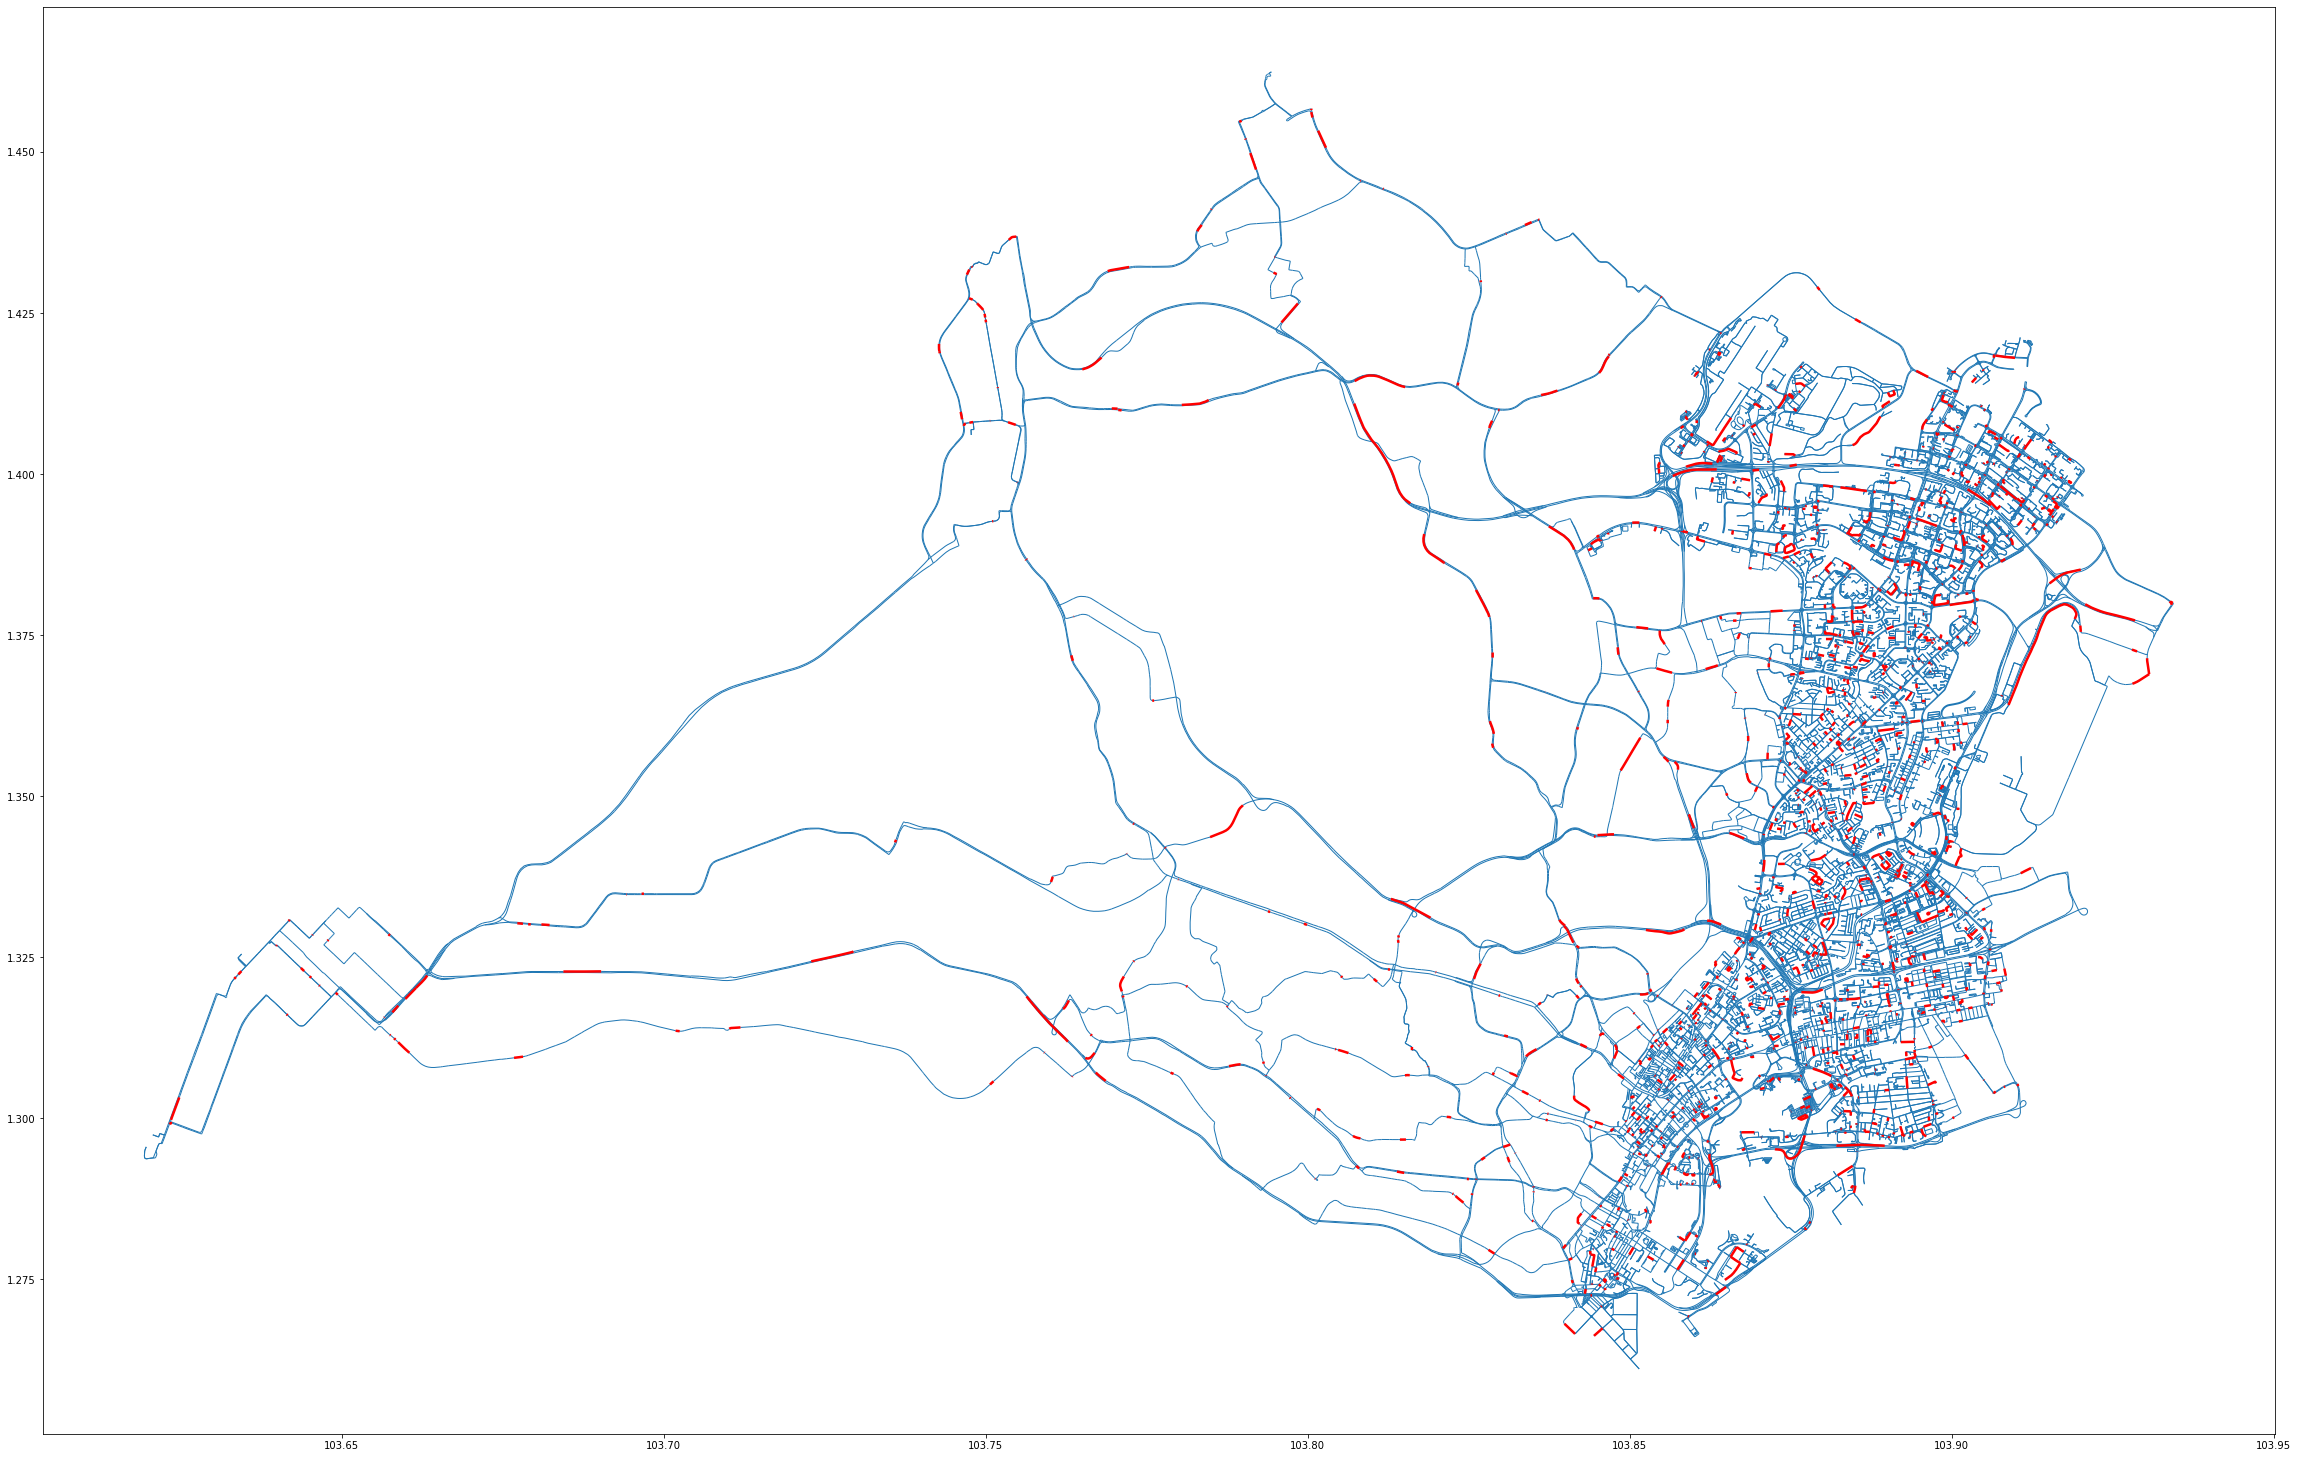

In [120]:
network_info.network_gdf()
network_info.plot_required_arcs()

In [121]:
network_info.load_distance_matrix()

INFO:root:Load distance matrix: 2034 x 2034
INFO:root:Creating nearest neighbour lists


In [122]:
network_info.offload_calculations3D()

INFO:root:Calculate offloads: 2034 x 2034 x 4


In [123]:
demand = 1 # unit
df_demand = req_arcs[['arc_index']].copy()
df_demand['demand'] = 1
network_info.set_service_demand(df_demand)

service_speed = 1 / 3.6
service_costs = req_arcs[['arc_index', 'length']].copy()
service_costs['service_cost'] = service_costs['length'] / service_speed
network_info.set_service_cost(service_costs)

network_info.check_shapes()

INFO:root:Setting demand for network
INFO:root:Setting service cost for network


In [124]:
network_info.set_travel_speed(60 / 3.6)
network_info.set_offload_time(15 * 60)

network_info.update_cost_matrix()
network_info.update_offload_cost()

network_info.set_vechile_capacity_constraint(100)
network_info.set_vehicle_duration_constraint(10 * 60 * 60)

INFO:root:Update travel durations.
INFO:root:Update offload durations.


In [125]:
solution_df = solve_store_instance('', 
                                   improve = None, 
                                   write_results=False, 
                                   info=network_info, 
                                   overwrite=True, 
                                   test_solution=True, 
                                   full_output=False, 
                                   tollerance=60)

Problem info supplied. Directly proceeding to solve problem.


In [126]:
network_info.add_solution(solution_df)
network_info.deconstruct_solution()

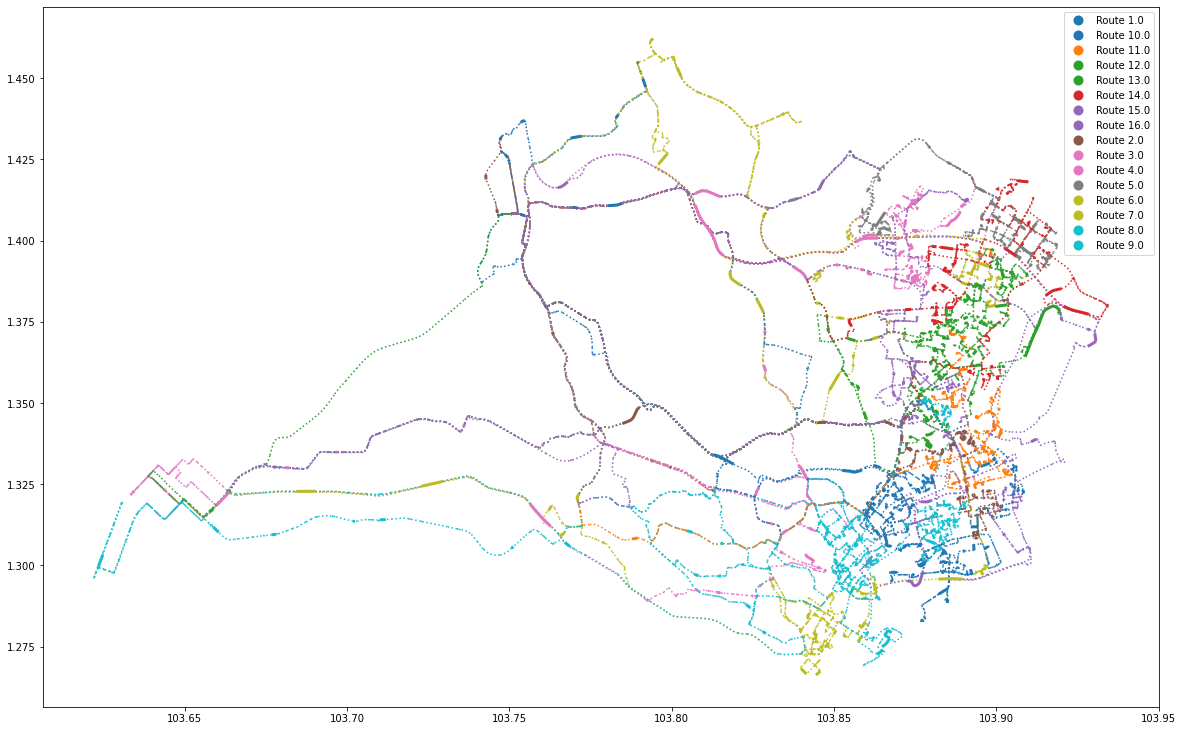

In [127]:
network_info.plot_routes(figsize=(20, 20))

In [145]:
network_info.df_solution_full.activity_type.unique()

array(['depot_start', 'collect', 'travel', 'offload', 'depot_end'],
      dtype=object)

In [171]:
route_summary = RouteSummary(network_info.df_solution_full, network_info)
route_sum_table = route_summary.route_summary()
pd.options.display.max_rows = max(25, route_sum_table.shape[0])
route_sum_table

,,Route,# offloads,Demand collected (kg),Time collecting (h),Time travelling (h),Time at treatment facility (h),Route duration (h),Total travel distance (km),Total collect distance (km),Total distance (km)
0,,1.0,1.0,100.0,7.76,1.76,0.25,9.78,106.38,7.72,114.10
1,,2.0,1.0,100.0,8.10,1.63,0.25,10.00,98.87,8.05,106.92
2,,3.0,1.0,55.0,7.45,2.30,0.25,10.01,138.35,7.42,145.78
3,,4.0,1.0,64.0,8.39,1.36,0.25,10.00,82.06,8.36,90.42
4,,5.0,2.0,118.0,7.94,1.52,0.50,9.97,92.02,7.88,99.90
5,,6.0,1.0,81.0,7.77,1.97,0.25,10.01,119.07,7.73,126.80
6,,7.0,1.0,65.0,7.56,2.19,0.25,10.00,131.70,7.52,139.22
7,,8.0,2.0,125.0,7.55,1.91,0.50,9.98,115.65,7.49,123.14
8,,9.0,1.0,97.0,7.07,2.67,0.25,10.00,160.83,7.02,167.85
9,,10.0,1.0,99.0,7.75,2.00,0.25,10.01,121.02,7.70,128.71


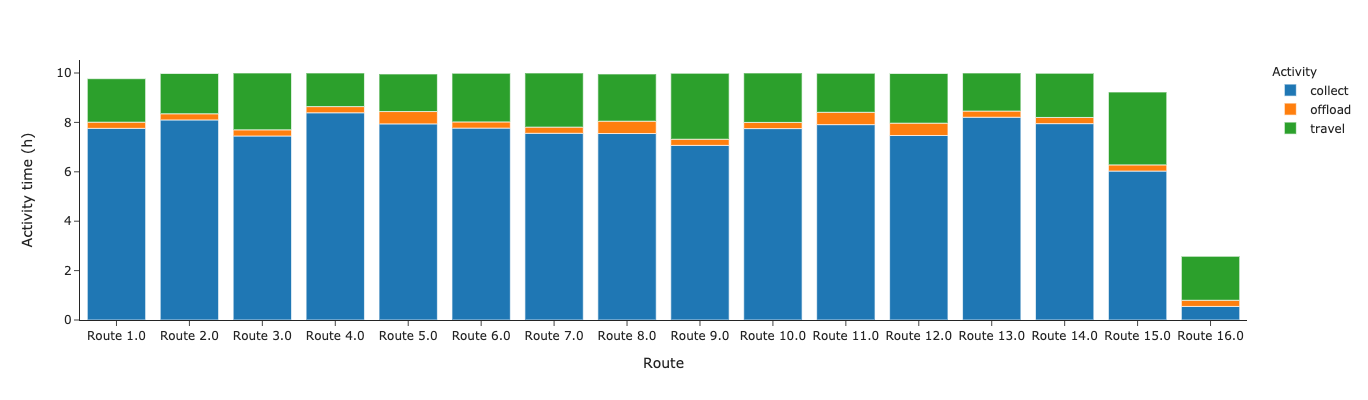

In [157]:
route_summary.route_trip_time_summary_bar()

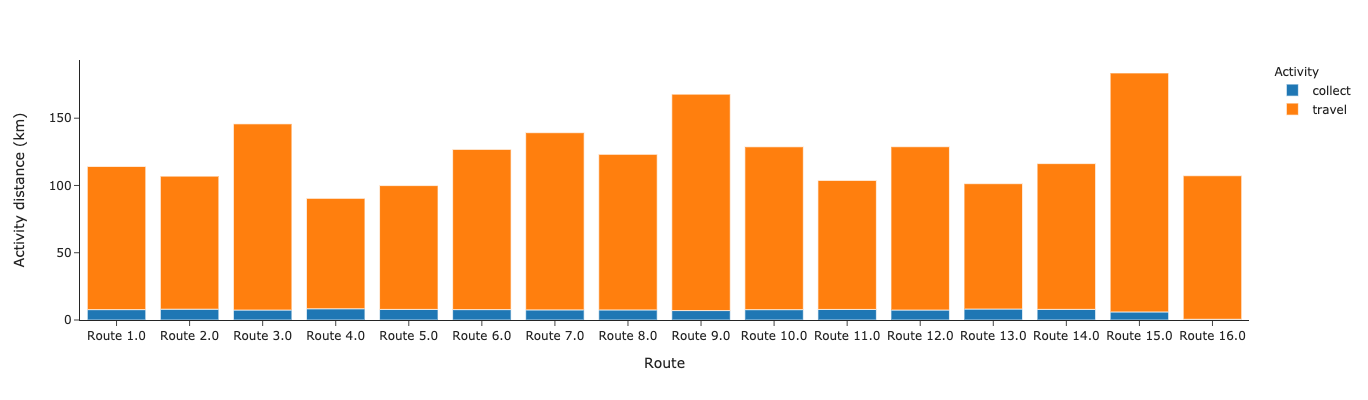

In [159]:
route_summary.route_trip_distance_summary_bar()

In [130]:
subtrip_summary = route_summary.subtrip_summary()
pd.options.display.max_rows = max(25, subtrip_summary.shape[0])
subtrip_summary

,route,subroute,demand_collected,activity_time,travel_time,total_time
0,1,1,100.0,8.01,1.76,9.77
1,2,1,100.0,8.35,1.63,9.98
2,3,1,55.0,7.70,2.30,10.00
3,4,1,64.0,8.64,1.36,9.99
4,5,1,100.0,7.10,1.04,8.14
5,5,2,18.0,1.33,0.48,1.82
6,6,1,81.0,8.02,1.97,9.99
7,7,1,65.0,7.81,2.19,9.99
8,8,1,100.0,6.18,1.42,7.60
9,8,2,25.0,1.87,0.49,2.36


In [172]:
network_info.add_traversal_time()
network_info.add_time_formatted()
network_info.add_constant_duration_time()

In [174]:
network_info.df_solution_full.to_csv('temp/route_full_test.csv', index=False)